# Package installation

In [1]:
!pip install zarr
# Then restart the runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 72.6 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=e87c14d85ae0c02510bdd22916b19d6e81f7c3c5ecb14ee5621366eb81e0e0bd
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp /content/drive/MyDrive/hrrr17x.tgz hrrr17x.tgz
!tar -xzf hrrr17x.tgz # we should have the hrrr17x.zarr file

In [4]:
!cp /content/drive/MyDrive/mds.tar.gz mds.tar.gz
!tar -xzf mds.tar.gz

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.metadata:kMDItemWhereFroms'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.metadata:kMDItemDownloadedDate'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.macl'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'


# Neural Network Declaration

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FullyConnectedNetwork(nn.Module):
    def __init__(self):
        super(FullyConnectedNetwork, self).__init__()

        # First fully connected layer
        self.fc1 = nn.Linear(25 * 25, 512)
        self.dropout1 = nn.Dropout(0.5)

        # Second fully connected layer
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.5)

        # Third fully connected layer
        self.fc3 = nn.Linear(256, 128)

        # Output layer
        self.fc4 = nn.Linear(128, 15)

    def forward(self, x):
        # Flatten the image input
        x = x.view(x.size(0), -1)

        # Pass through the first layer, apply ReLU and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        # Second layer
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        # Third layer
        x = F.relu(self.fc3(x))

        # Output layer with softmax activation
        x = self.fc4(x)
        x = F.log_softmax(x, dim=1)
        return x # x is log probability

# Create the neural network
model = FullyConnectedNetwork()

# Print the model structure
print(model)


FullyConnectedNetwork(
  (fc1): Linear(in_features=625, out_features=512, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=15, bias=True)
)


Define a custom DataLoader for our dataset format

In [6]:
class StormShadow(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx, :, :]
        label = self.labels[idx, :]
        return sample, label

Early stopping logic

In [7]:
import numpy as np

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.Inf
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True



# Load the data

In [8]:
import xarray as xr
vil_ds = xr.open_zarr('hrrr17x.zarr/')
vil_dr = vil_ds.VIL
# Get all the file names in bystormlabels folder
from tqdm import tqdm
import numpy as np
import os

labels = np.zeros((5625, 15))

for date_str in tqdm(vil_dr.attrs['date']):
    # Replace : with _ in date_str
    filename_to_open = date_str.replace(':', '_')
    # check if the file exists
    if not os.path.isfile('mds/bystormlabels/' + filename_to_open + '.npz'):
        continue
    labell = np.load('mds/bystormlabels/' + filename_to_open + '.npz')['arr_0']
    frequency_vector = np.array([(labell==i).sum() for i in range(15)])
    if frequency_vector.sum() == 0:
        continue
    else:
        # print(vil_dr.attrs['date'].index(date_str))
        pass
    labels[vil_dr.attrs['date'].index(date_str)] = frequency_vector / frequency_vector.sum()
vil_input = vil_dr.values

100%|██████████| 5625/5625 [00:02<00:00, 2038.47it/s]


In [9]:
# Convert to tensor
vil_tensor = torch.from_numpy(vil_input)
labels_tensor = torch.from_numpy(labels) # in normal form, NOT log probability

In [10]:
def normalize_vil_input_by_max(vil_tensor):
    vil_tensor = vil_tensor - vil_tensor.min()
    vil_tensor = vil_tensor / vil_tensor.max()
    return vil_tensor

def normalize_vil_input_by_mean_and_std(vil_tensor):
    vil_tensor = vil_tensor - vil_tensor.mean()
    vil_tensor = vil_tensor / vil_tensor.std()
    return vil_tensor

vil_tensor = normalize_vil_input_by_mean_and_std(vil_tensor)

In [11]:
# Split the data into training, validation and test sets
train_split = 0.8
val_split = 0.1
test_split = 0.1

from torch.utils.data import random_split

# Calculate lengths of splits
train_length = int(train_split * len(vil_tensor))
val_length = int(val_split * len(vil_tensor))
test_length = len(vil_tensor) - train_length - val_length

# Split the data
train_data, val_data, test_data = random_split(vil_tensor, [train_length, val_length, test_length])

# Print the size of the splits
print('Train data length: ', len(train_data))
print('Val data length: ', len(val_data))
print('Test data length: ', len(test_data))

Train data length:  4500
Val data length:  562
Test data length:  563


# Network hyperparameters configuration

In [12]:
# Training setup
# Create dataset
dataset = StormShadow(vil_tensor, labels_tensor)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

# Define the model
model = FullyConnectedNetwork()

# Define the loss
criterion = nn.KLDivLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Number of epochs to train the model
n_epochs = 10

In [13]:
# Setup early stopping
early_stopping = EarlyStopping(patience=50, min_delta=1e-2)

# Train the Network

In [14]:
# Tensorboard setup
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/stormshadow')

In [22]:
# Train and Evaluation Loops

def train_one_epoch(model, train_loader, loss_function, optimizer, device):
    model.train()
    total_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        # Forward pass
        output = model(data)
        loss = loss_function(output, target)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

def evaluate(model, data_loader, loss_function, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_function(output, target)
            total_loss += loss.item()

    return total_loss / len(data_loader)

def train_model(model, train_loader, valid_loader, loss_function, optimizer, num_epochs, device):
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, loss_function, optimizer, device)
        valid_loss = evaluate(model, valid_loader, loss_function, device)

        # Record the training loss
        writer.add_scalar('Loss/train', train_loss / len(train_loader), epoch)
        writer.add_scalar('Loss/valid', valid_loss / len(valid_loader), epoch)
        writer.add_scalar('Accuracy/train', 1 - train_loss / len(train_loader), epoch)
        writer.add_scalar('Accuracy/valid', 1 - valid_loss / len(valid_loader), epoch)

        # Early stopping
        early_stopping(valid_loss)

        if early_stopping.early_stop:
            pass
            #print("Early stopping triggered")
            #break

        if epoch % 20 == 0:
          print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}')

# Assuming a CUDA-capable device is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Train the model
num_epochs = 200  # maximum number of epochs
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

# Evaluate on the test set
test_loss = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}')

Epoch 1/200, Training Loss: 0.0163, Validation Loss: 0.0133
Epoch 21/200, Training Loss: 0.0164, Validation Loss: 0.0132
Epoch 41/200, Training Loss: 0.0168, Validation Loss: 0.0132
Epoch 61/200, Training Loss: 0.0161, Validation Loss: 0.0132
Epoch 81/200, Training Loss: 0.0161, Validation Loss: 0.0132
Epoch 101/200, Training Loss: 0.0161, Validation Loss: 0.0132
Epoch 121/200, Training Loss: 0.0162, Validation Loss: 0.0132
Epoch 141/200, Training Loss: 0.0161, Validation Loss: 0.0132
Epoch 161/200, Training Loss: 0.0161, Validation Loss: 0.0132
Epoch 181/200, Training Loss: 0.0160, Validation Loss: 0.0132
Test Loss: 0.0132


In [23]:
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [24]:
# Save the model to a file
torch.save(model, 'storm_shadow_2.pth')

In [25]:
!cp storm_shadow_2.pth /content/drive/MyDrive/storm_shadow_2.pth # copy the model to Google Drive

# Evaluation

We must run all code blocks above, except for those under the Train the model section.

In [ ]:
!cp /content/drive/MyDrive/storm_shadow_2.pth storm_shadow_2.pth

In [ ]:
import torch

model = torch.load('storm_shadow_2.pth')
print(model)

FullyConnectedNetwork(
  (fc1): Linear(in_features=625, out_features=512, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=15, bias=True)
)


In [26]:
model.eval() # switch to evaluation mode

FullyConnectedNetwork(
  (fc1): Linear(in_features=625, out_features=512, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=15, bias=True)
)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

FullyConnectedNetwork(
  (fc1): Linear(in_features=625, out_features=512, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=15, bias=True)
)

In [32]:
test_loader_for_eval = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
test_labels_vec = []
test_predic_vec = []
for vil_test, label_test in tqdm(test_loader_for_eval):
  vil_test = vil_test.to(device)
  with torch.no_grad():
    prob = torch.exp(model(vil_test)) # unsqueeze is to add the batch dimension so that it matches what is fed to the NN via the dataloader
    prob_np = prob.cpu().numpy()
    test_predic_vec.append(prob_np)
    test_labels_vec.append(label_test.numpy())

100%|██████████| 5625/5625 [00:05<00:00, 1074.73it/s]


In [33]:
from matplotlib import pyplot as plt

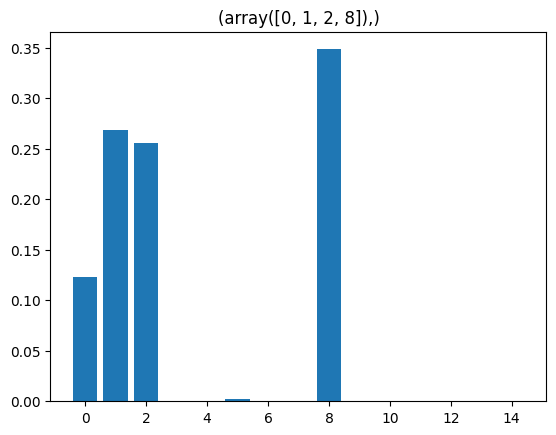

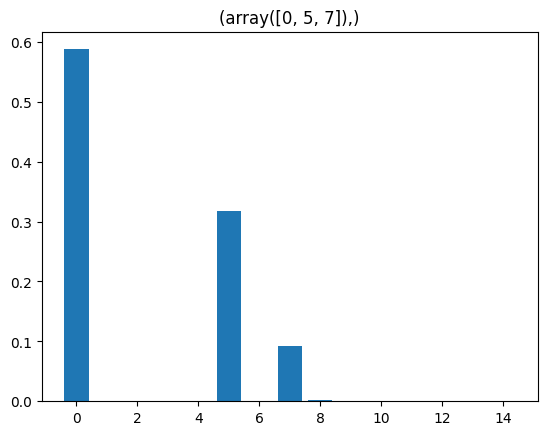

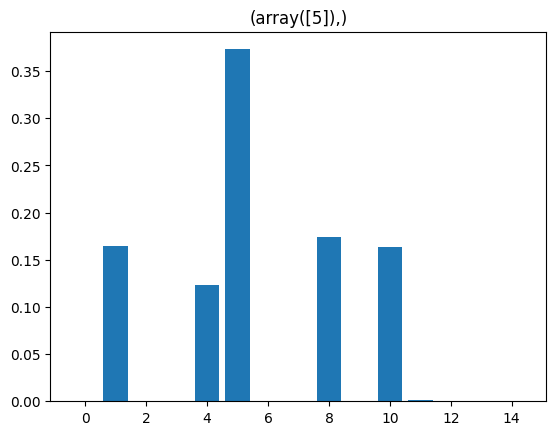

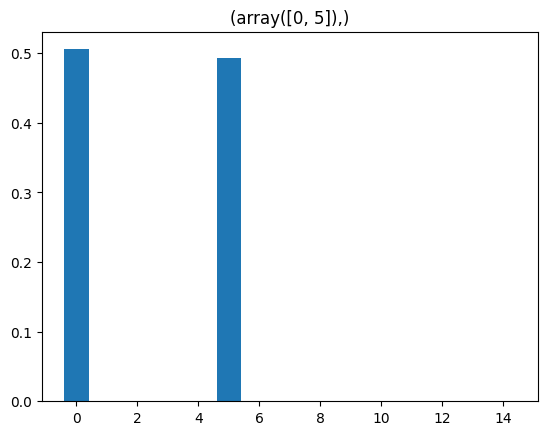

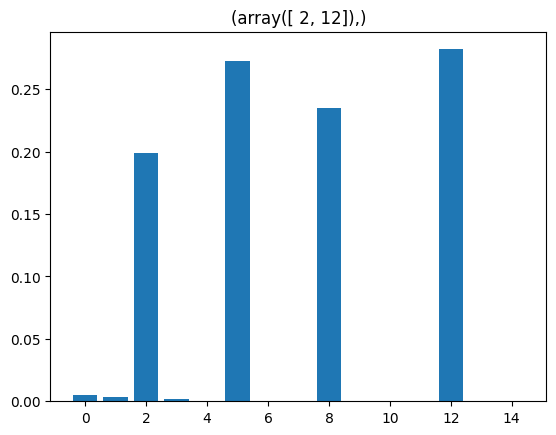

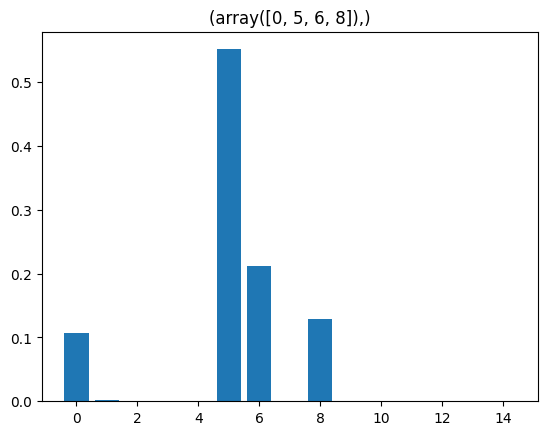

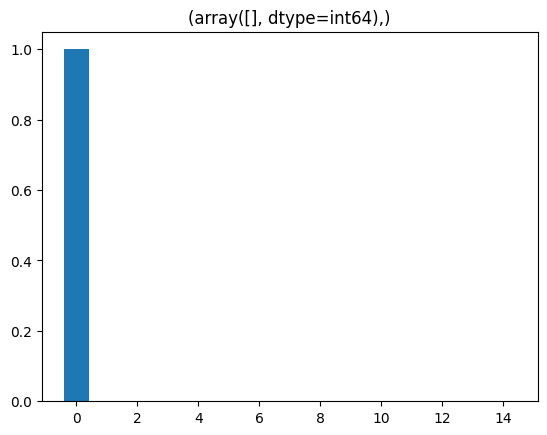

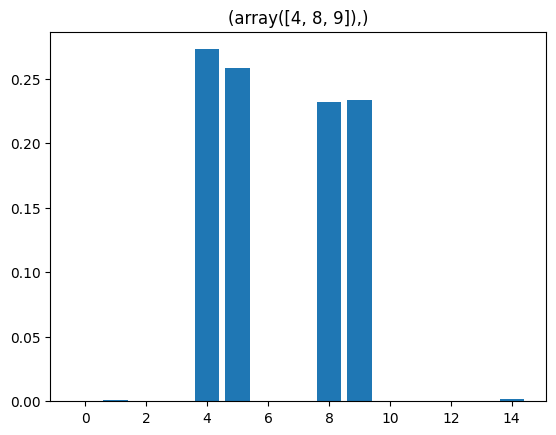

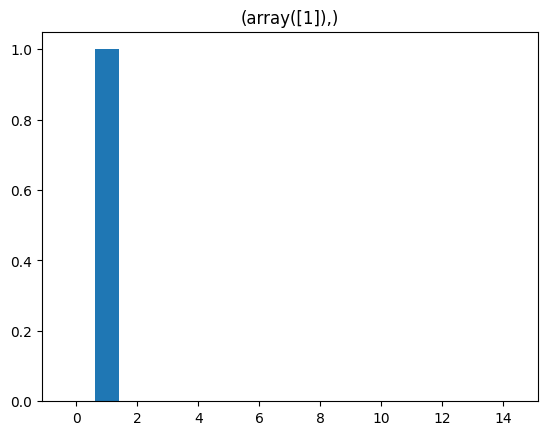

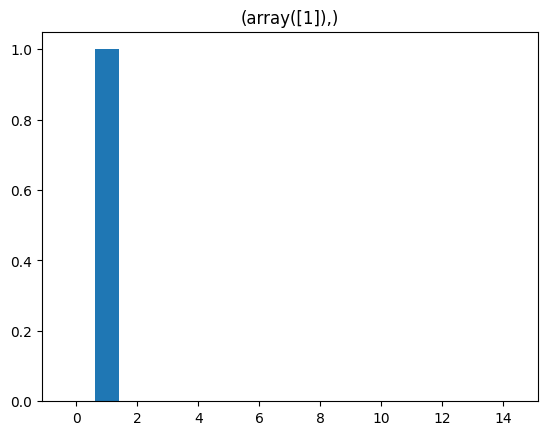

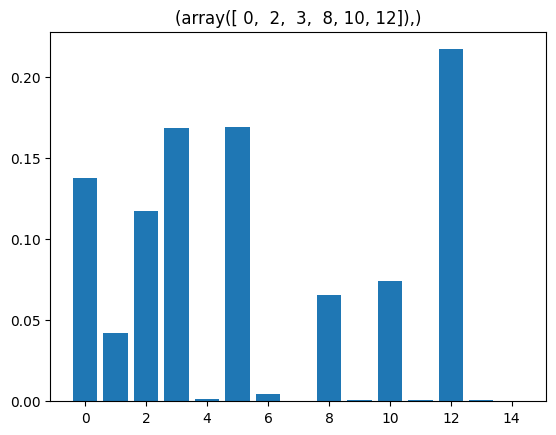

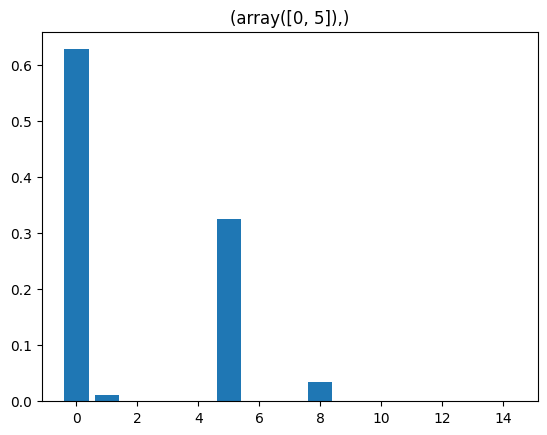

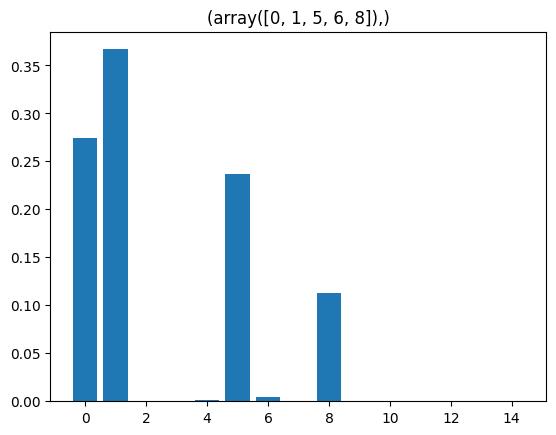

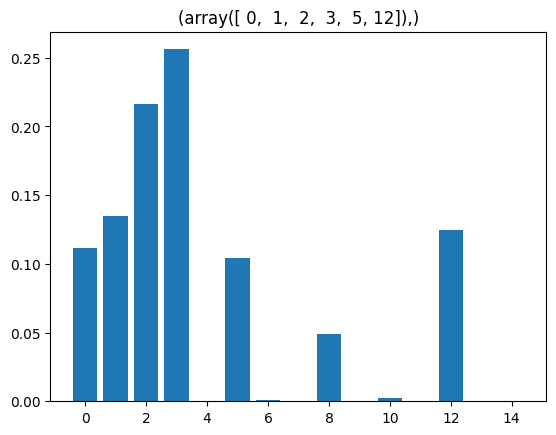

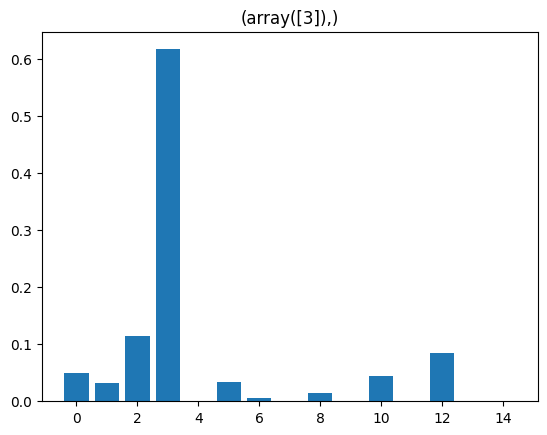

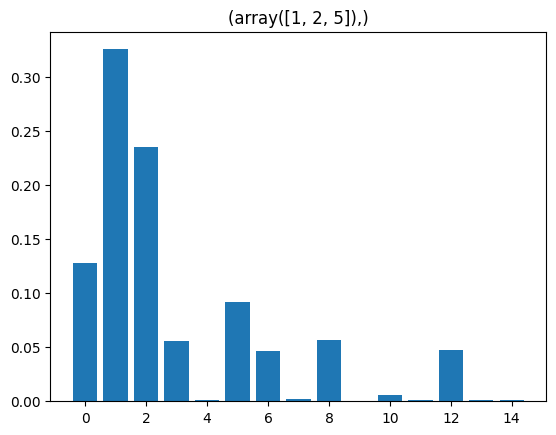

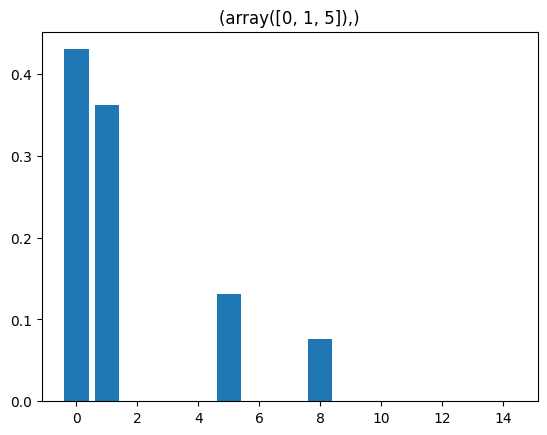

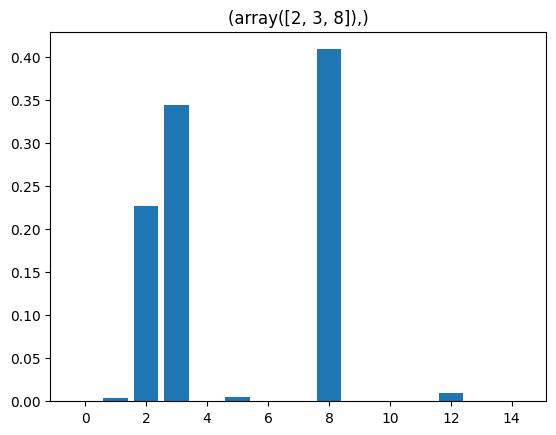

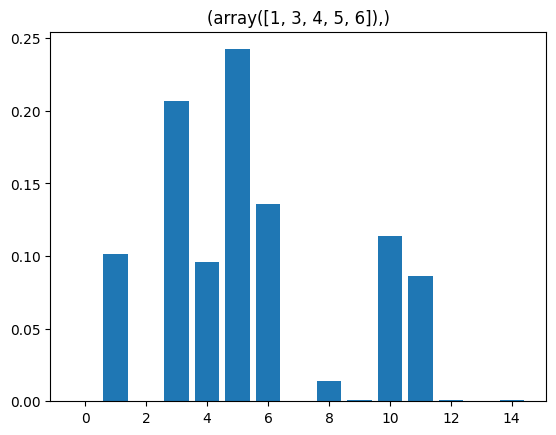

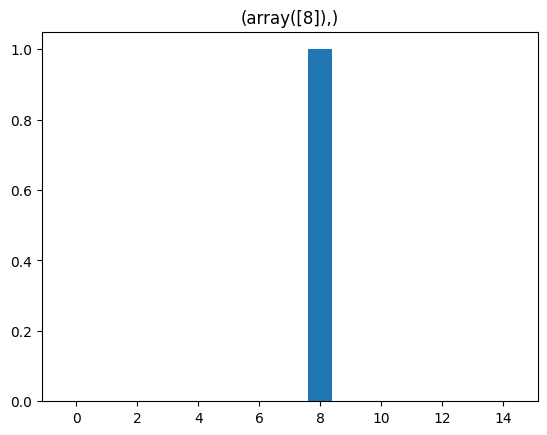

In [35]:
example_id = np.random.choice(len(test_loader_for_eval), 20)
for i in range(20):
  plt.figure()
  plt.title(np.where(test_labels_vec[i].flatten() > 0.05))
  plt.bar(np.arange(15), test_predic_vec[i].flatten())